In [10]:
!python3 -m pip install pandas --user --upgrade setuptools
!python3 -m pip install --upgrade pip --user
!python3 -m pip install gdown --user
!python3 -m pip install pandas --user
!python3 -m pip install tensorflow --user
#!python3 -m pip install tensorflow-gpu --user
!python3 -m pip install seaborn --user
!python3 -m pip install sklearn --user

Requirement already up-to-date: pandas in /home/animeshs/.local/lib/python3.5/site-packages (0.24.2)
Requirement already up-to-date: setuptools in /home/animeshs/.local/lib/python3.5/site-packages (45.3.0)
Requirement already up-to-date: pip in /home/animeshs/.local/lib/python3.5/site-packages (20.0.2)


     |████████████████████████████████| 7.0 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 41.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=d53aa1fd6bdf6e8a8df63866e3ca30a60883d32a89a8bc15374c978336dc708e
  Stored in directory: /home/animeshs/.cache/pip/wheels/9e/ec/a6/33cdb5605b0b150074213e154792654a1006e6e6807dc7ca6f
Successfully built sklearn


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [12]:
!gdown --id 1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_ --output airbnb_nyc.csv

Downloading...
From: https://drive.google.com/uc?id=1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_
To: /home/animeshs/promec/promec/Animesh/notebooks/Deploy-Keras-Deep-Learning-Model-with-Flask/price_prediction/airbnb_nyc.csv
7.08MB [00:00, 23.9MB/s]


In [13]:
df = pd.read_csv('airbnb_nyc.csv')

# Exploration

In [14]:
df.shape

(48895, 16)

In [15]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

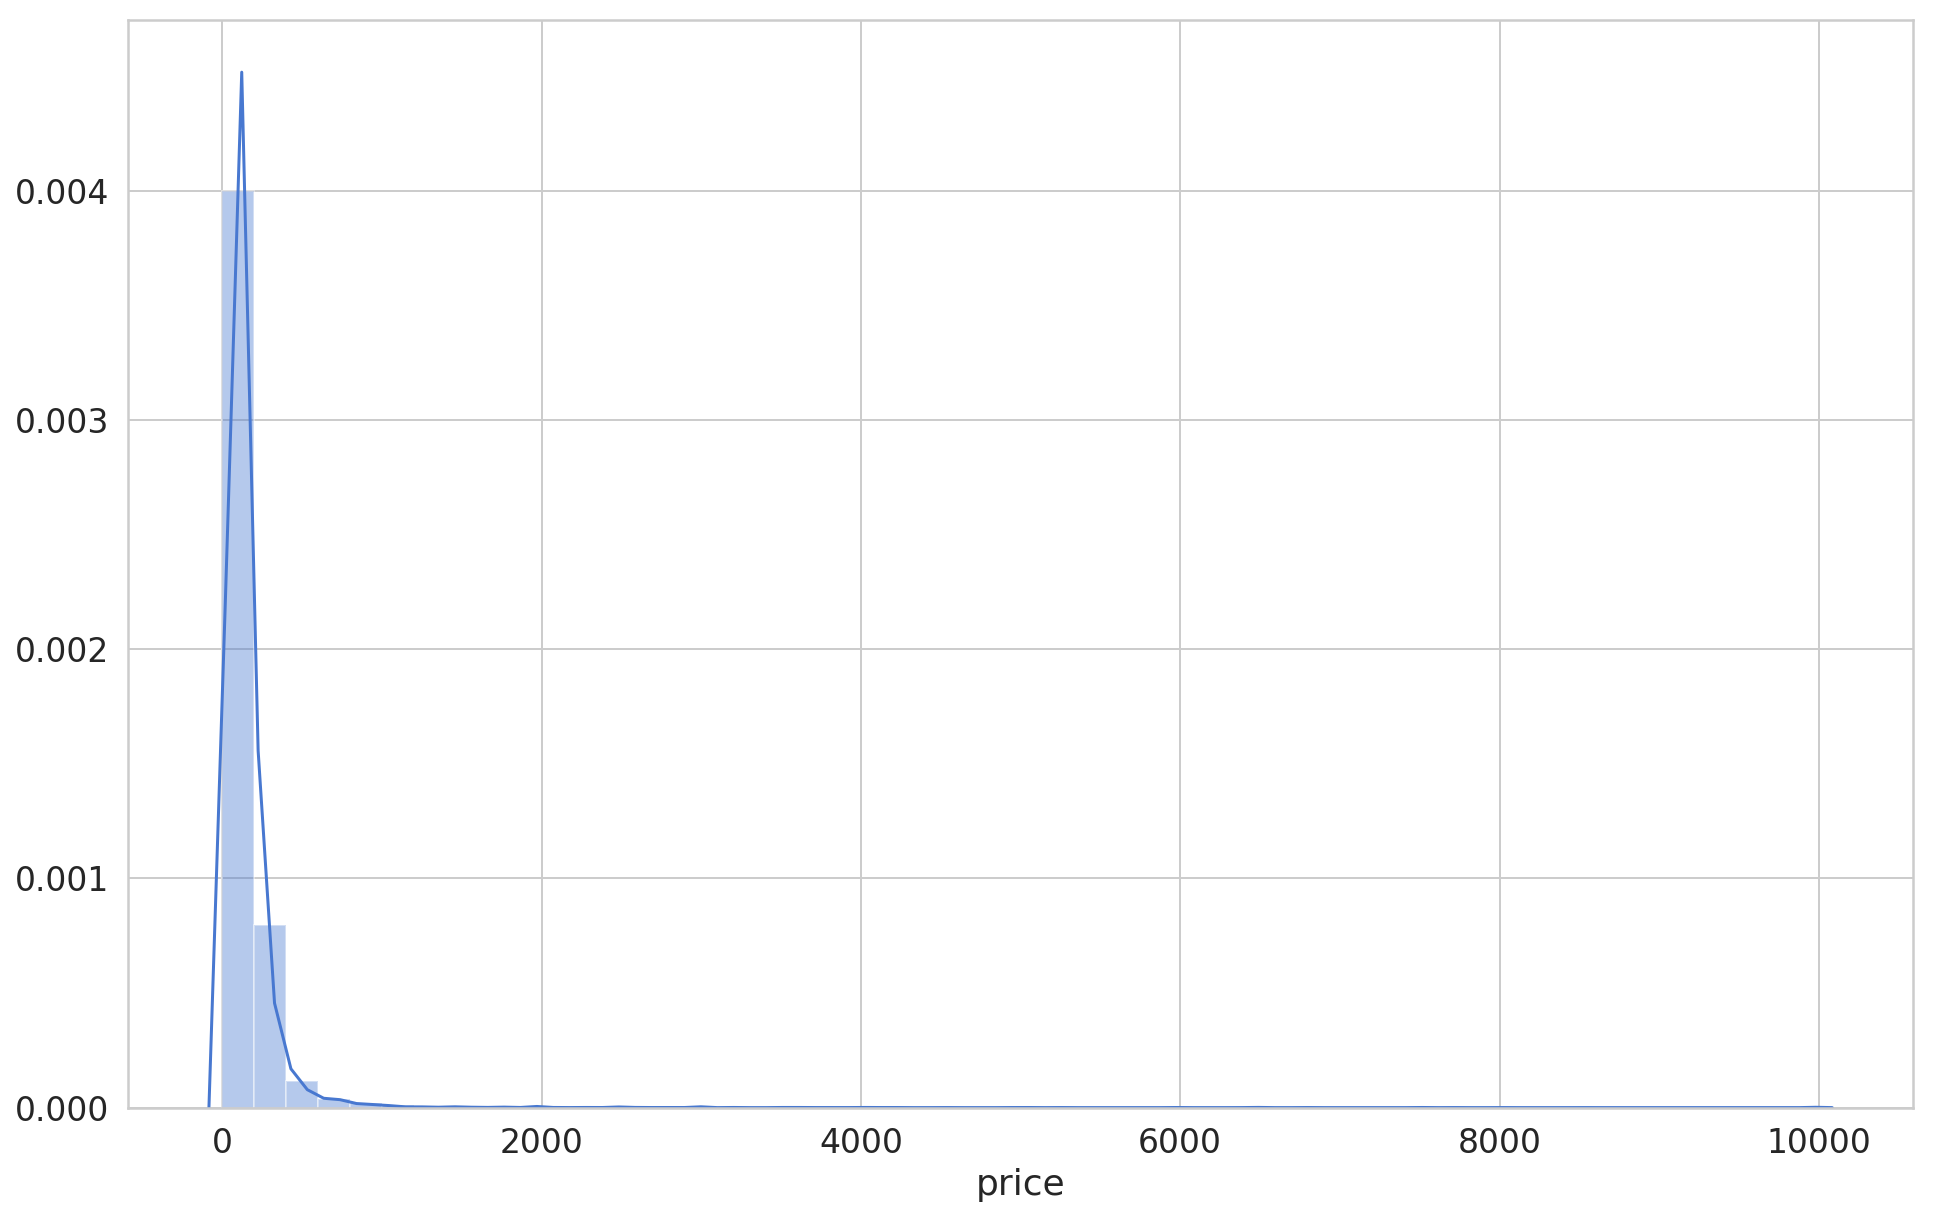

In [16]:
sns.distplot(df.price);

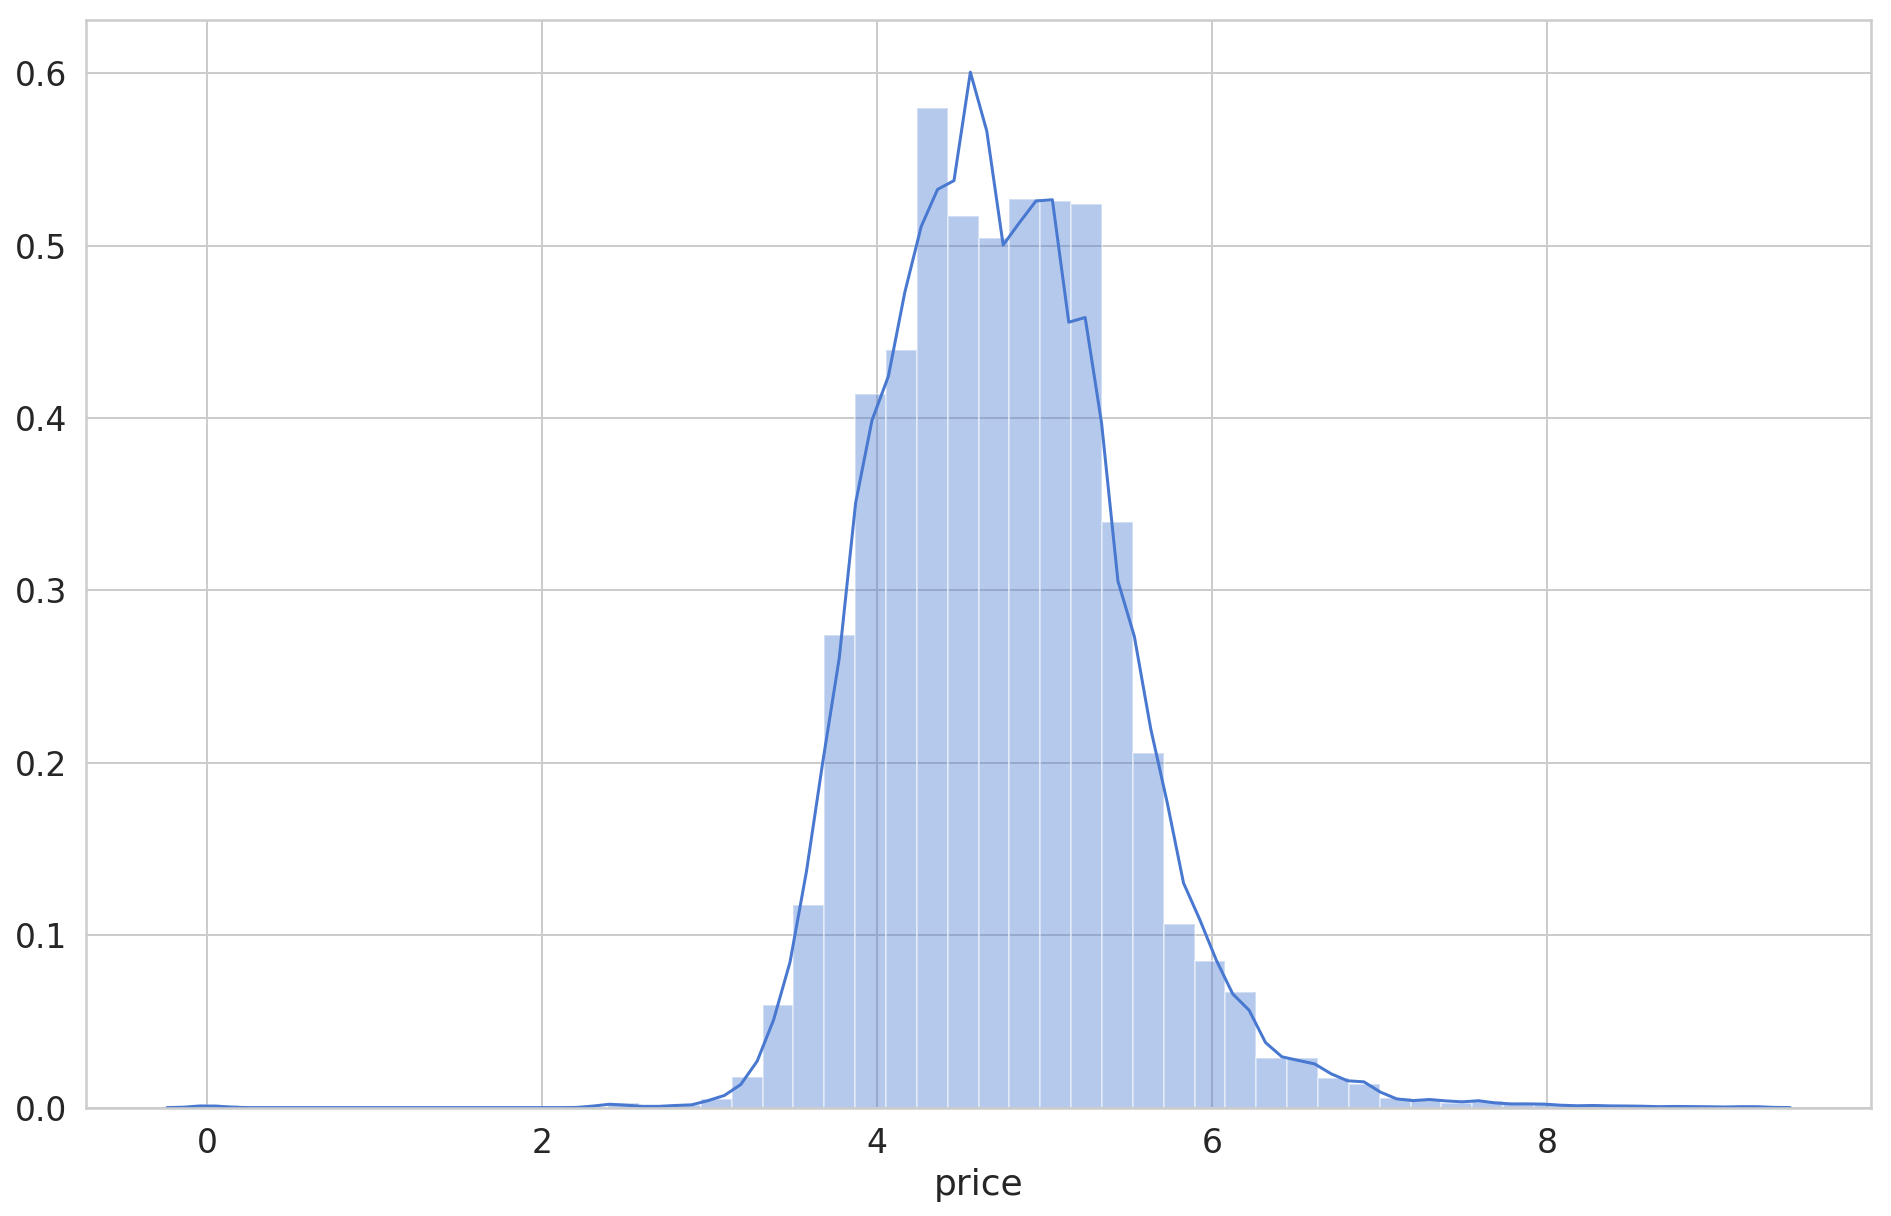

In [17]:
sns.distplot(np.log1p(df.price));

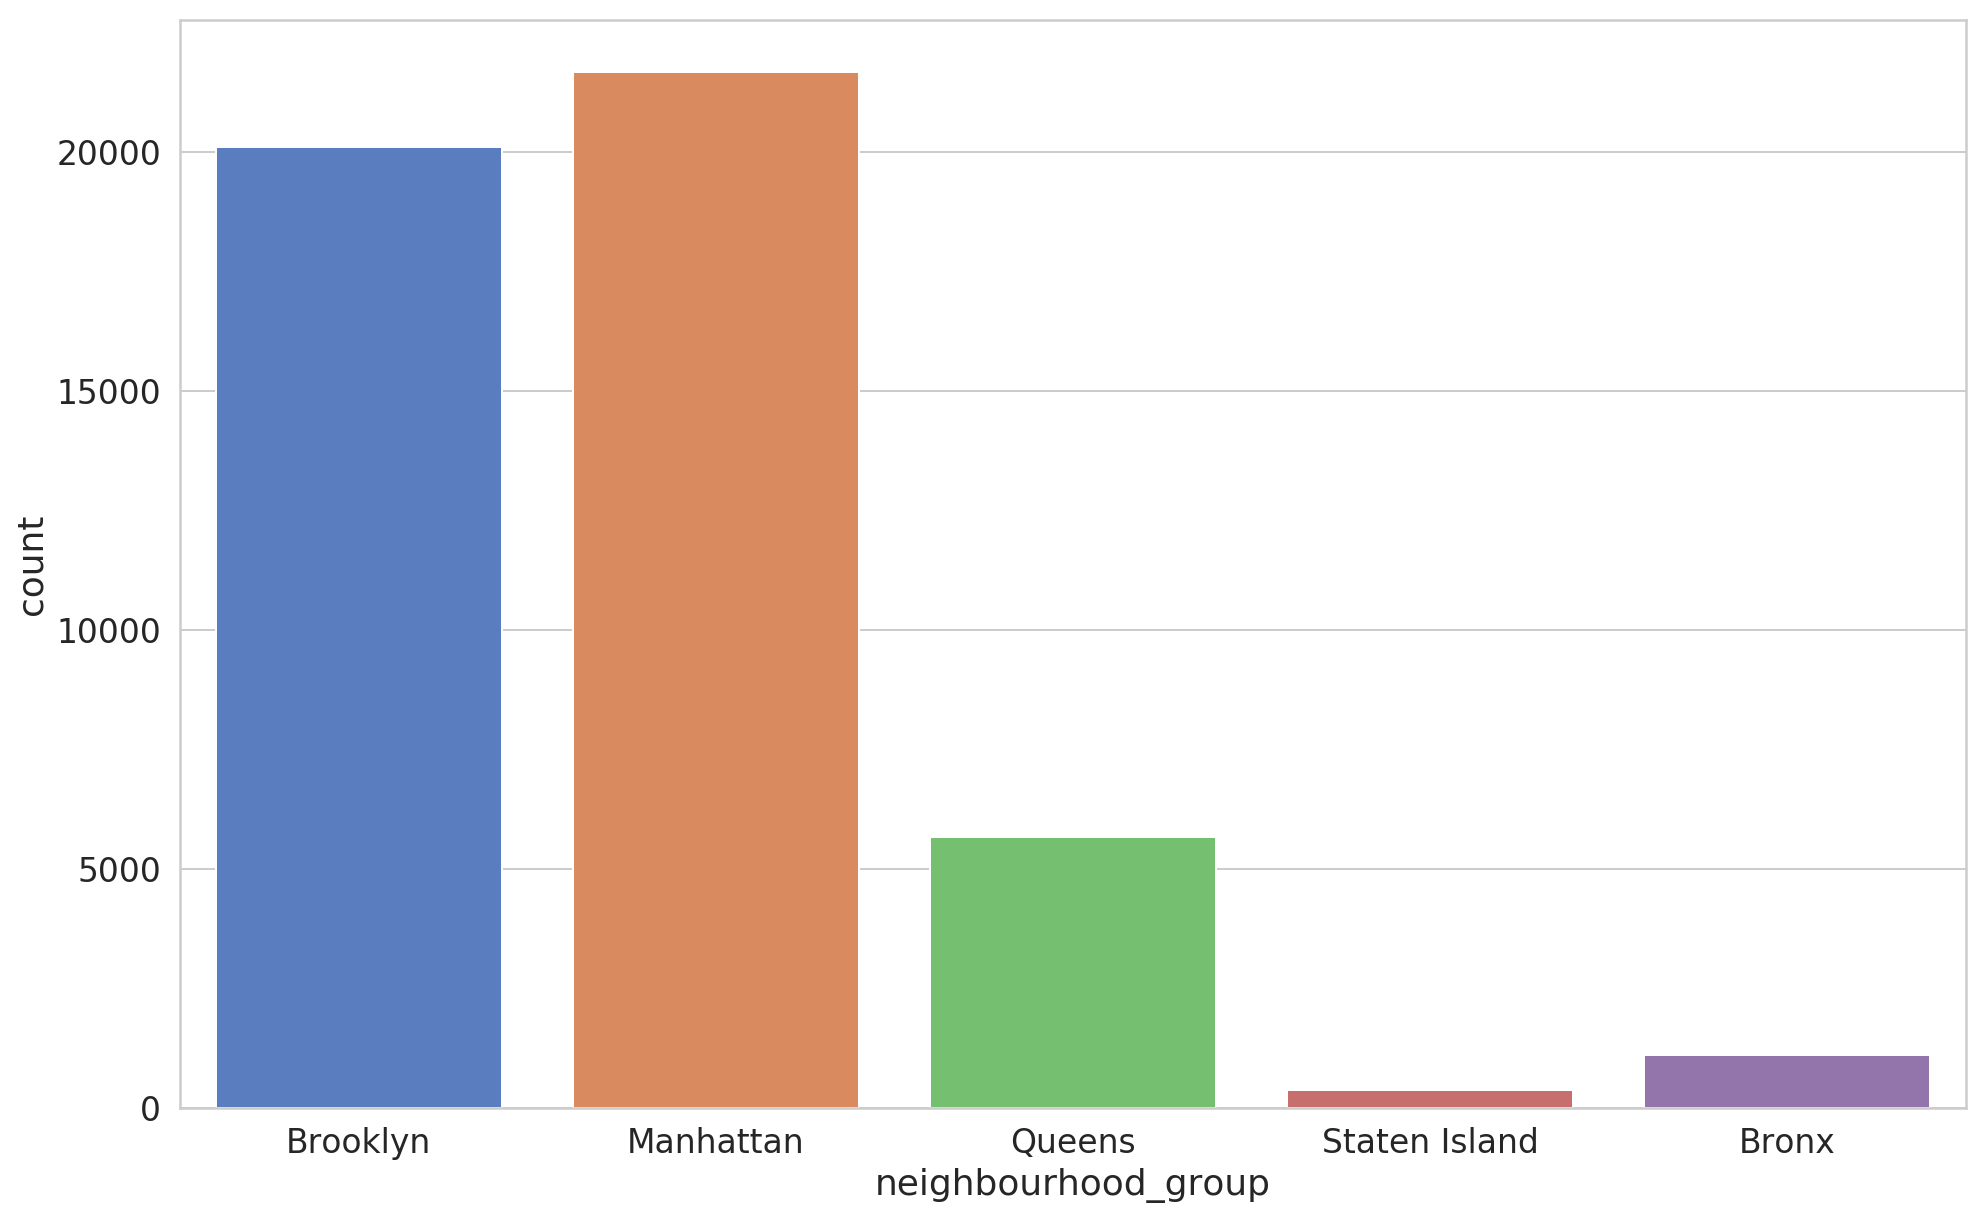

In [18]:
sns.countplot(x='neighbourhood_group', data=df);

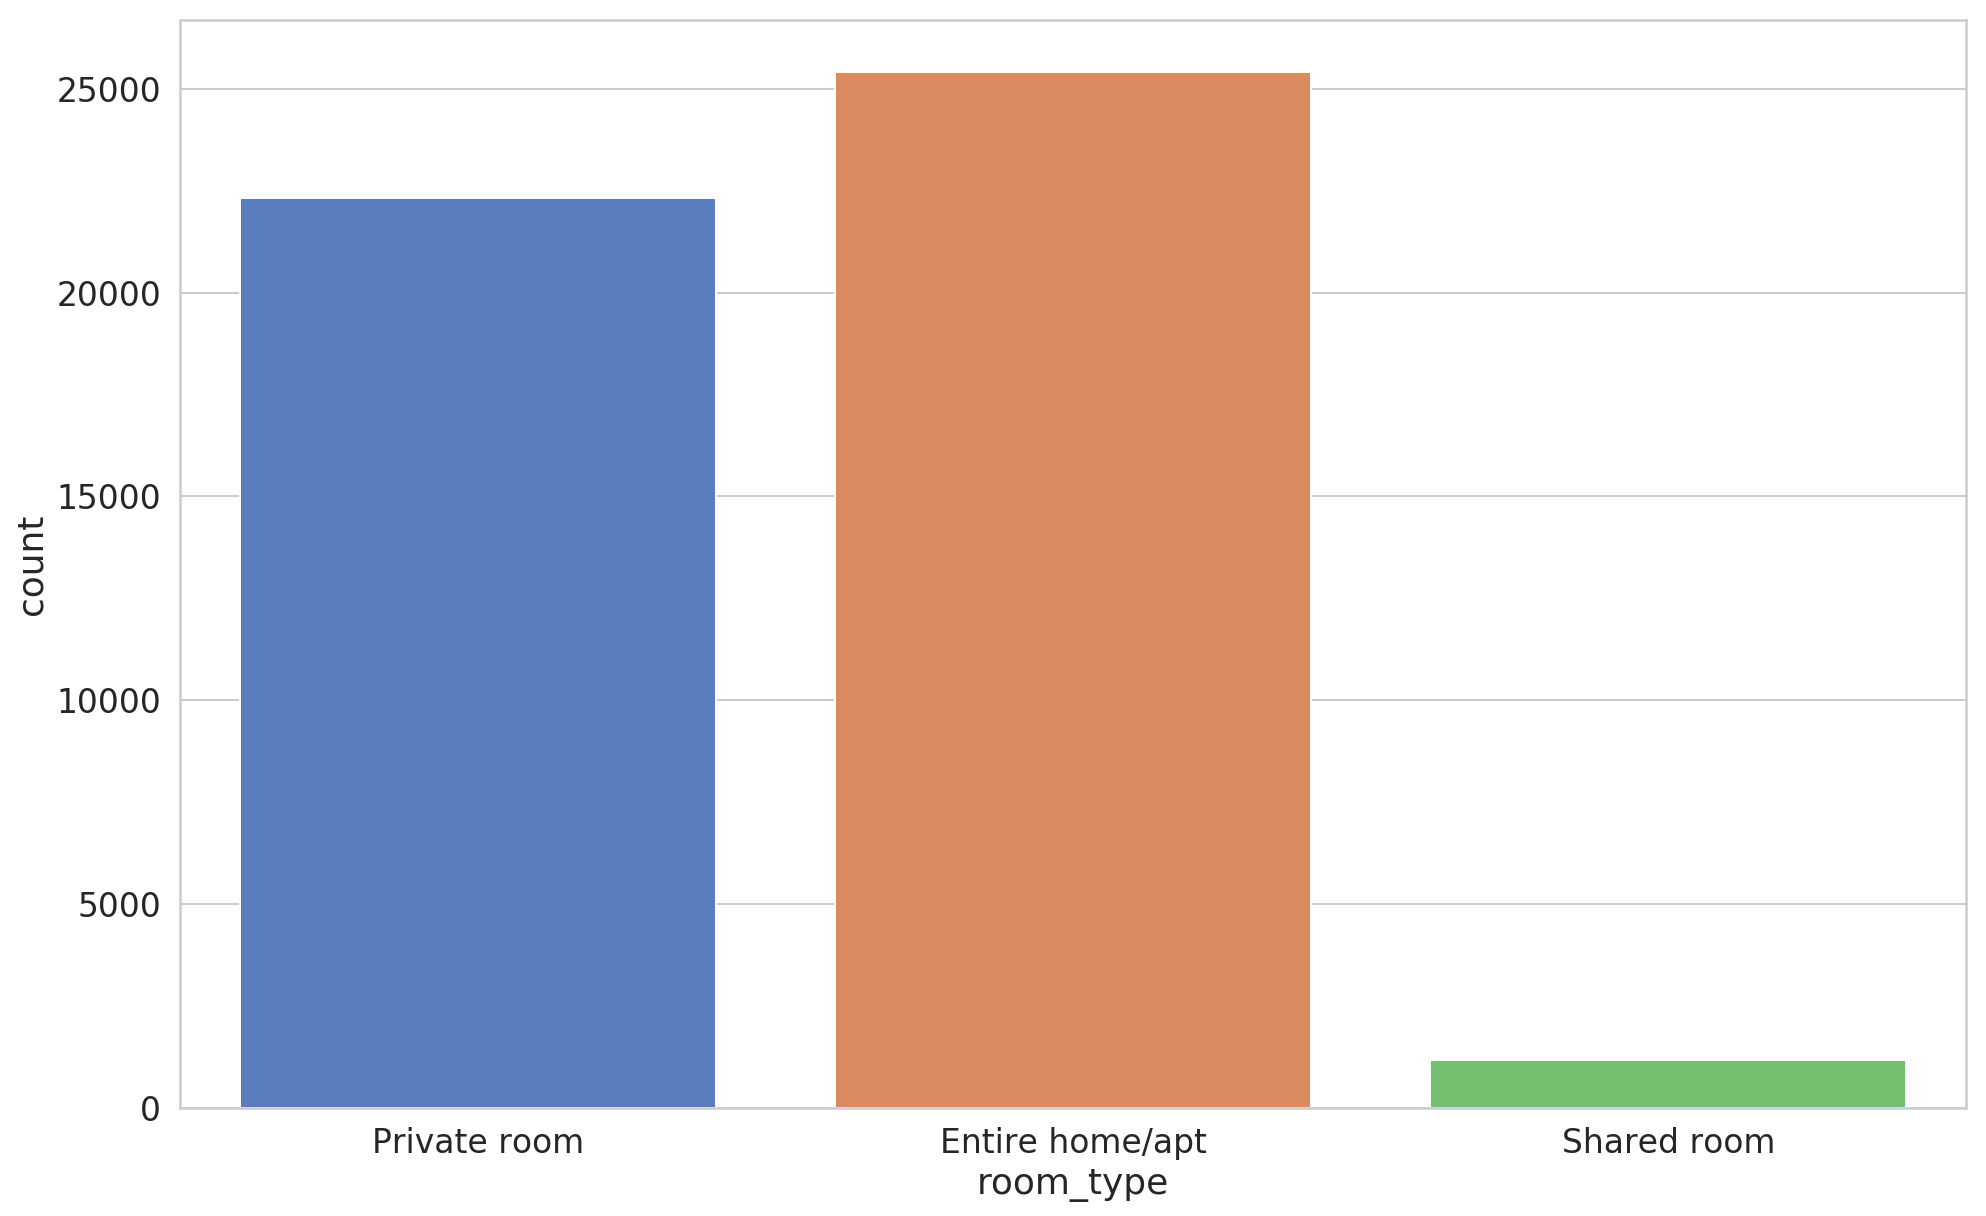

In [19]:
sns.countplot(x='room_type', data=df);

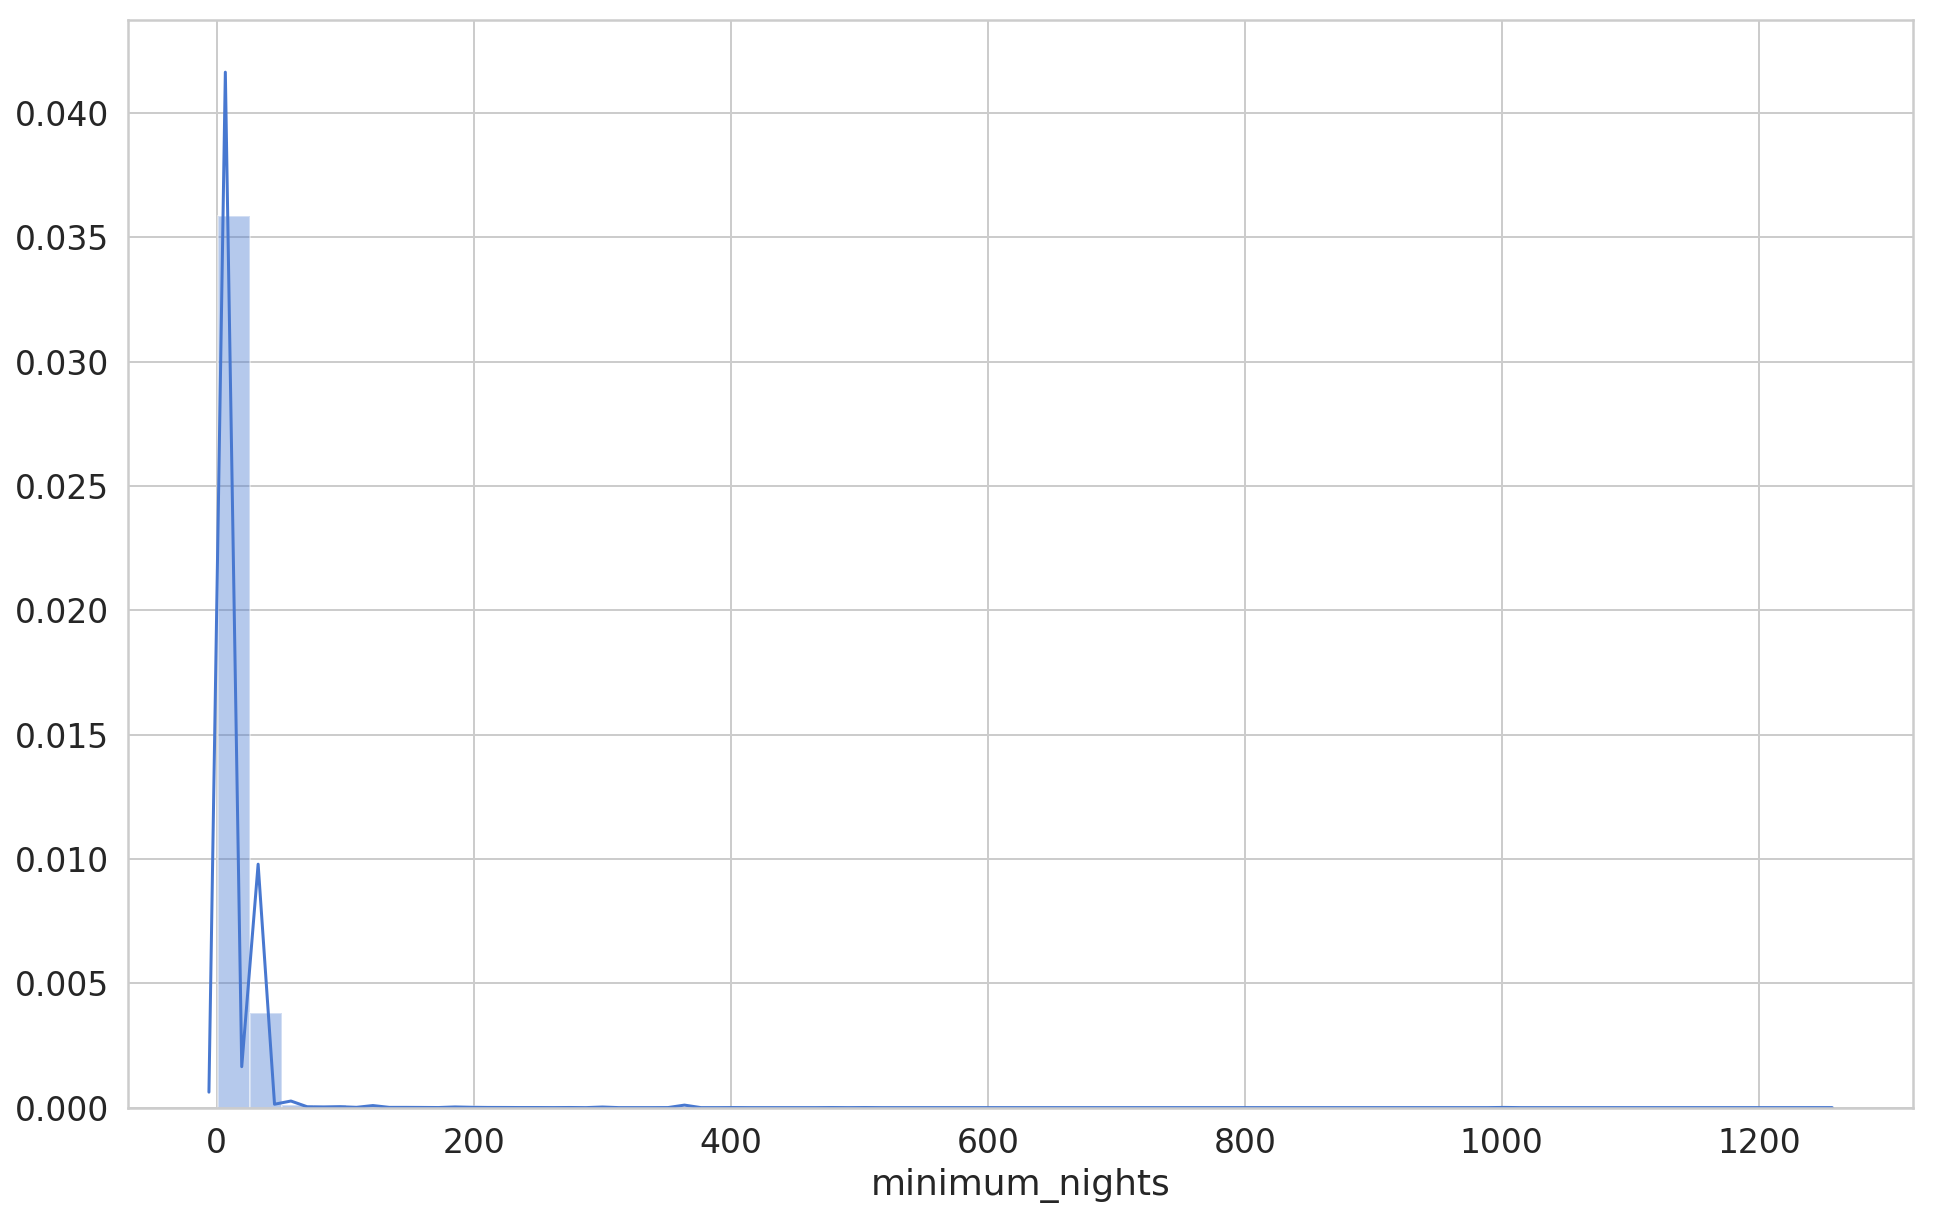

In [20]:
sns.distplot(df.minimum_nights);

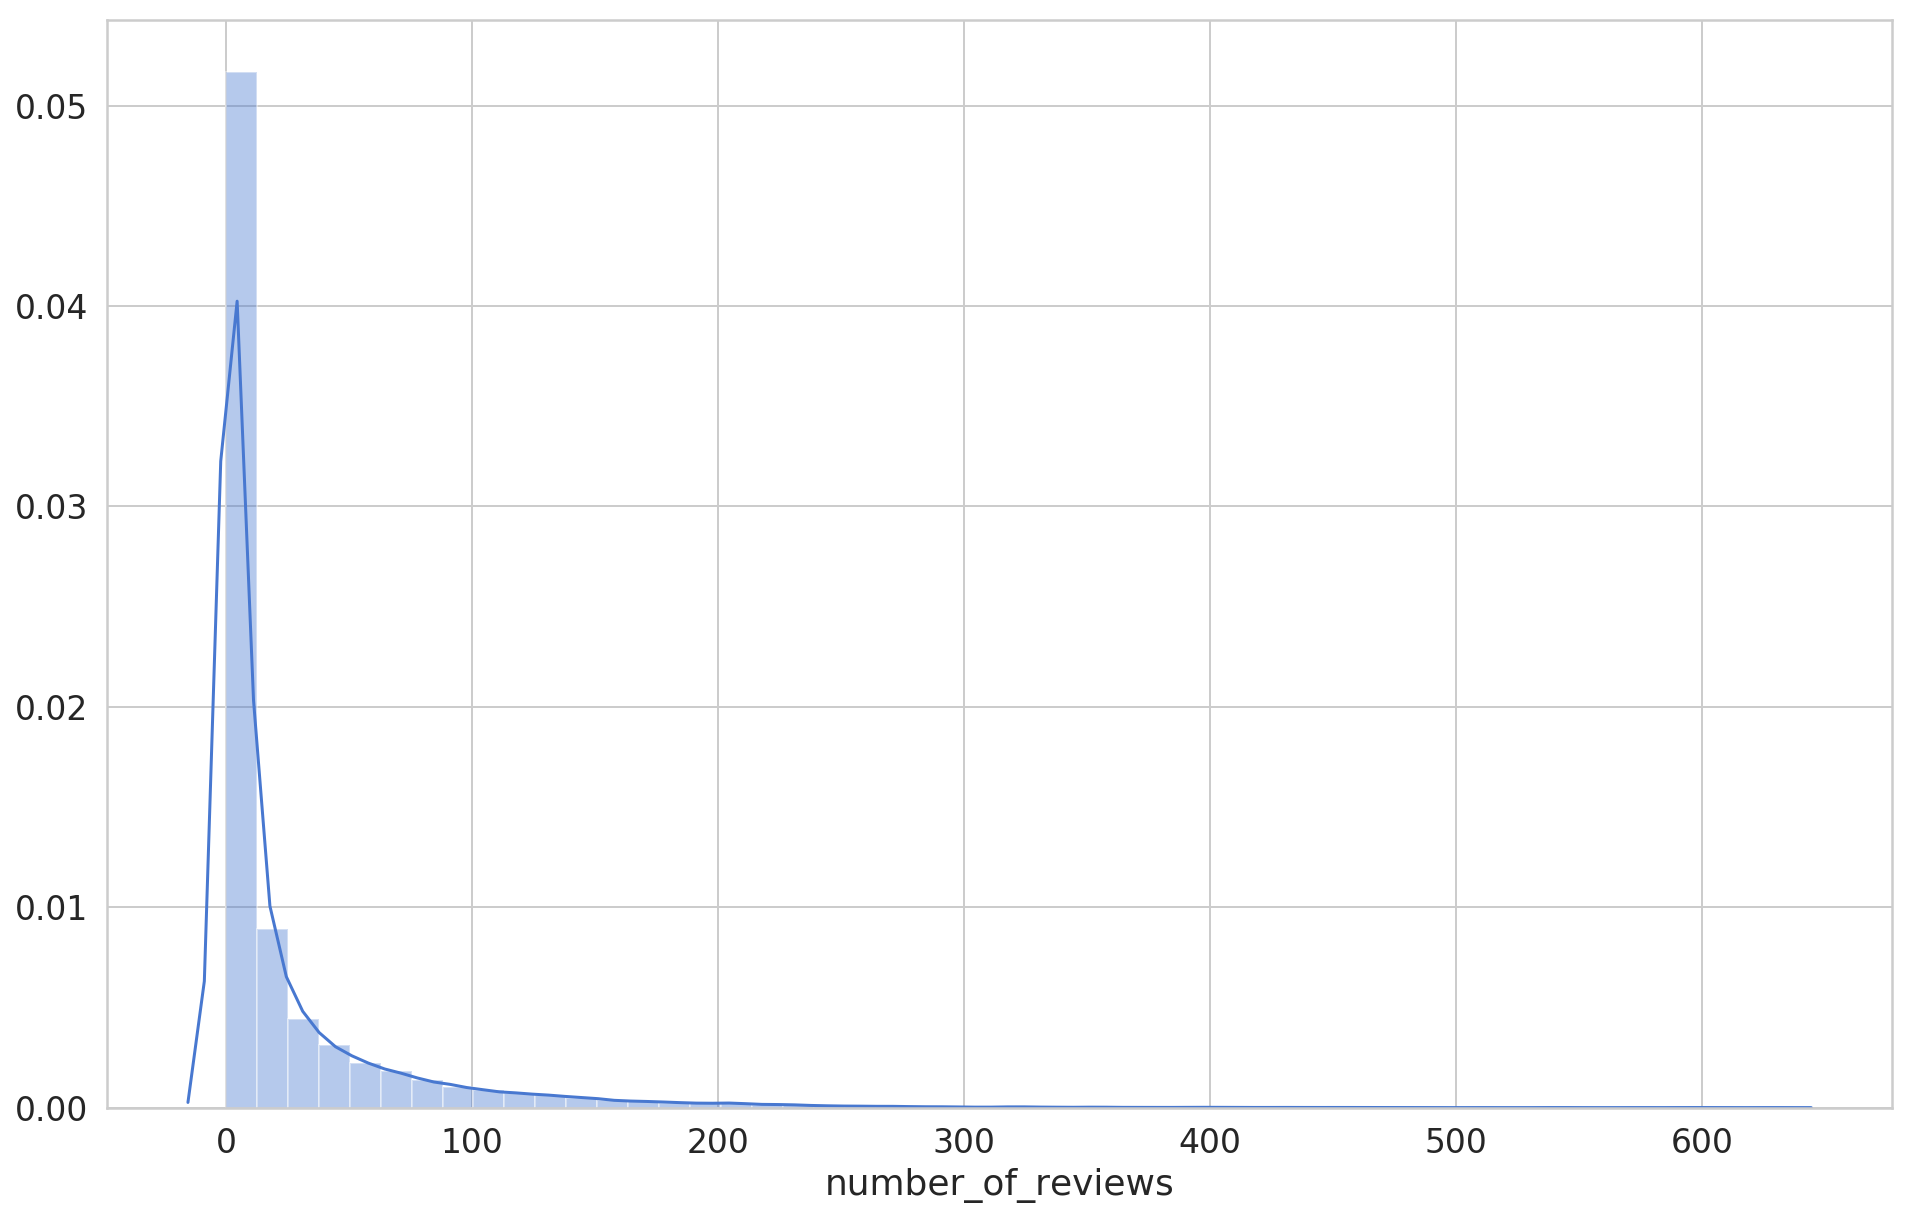

In [21]:
sns.distplot(df.number_of_reviews);

In [22]:
corr_matrix = df.corr()

In [23]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

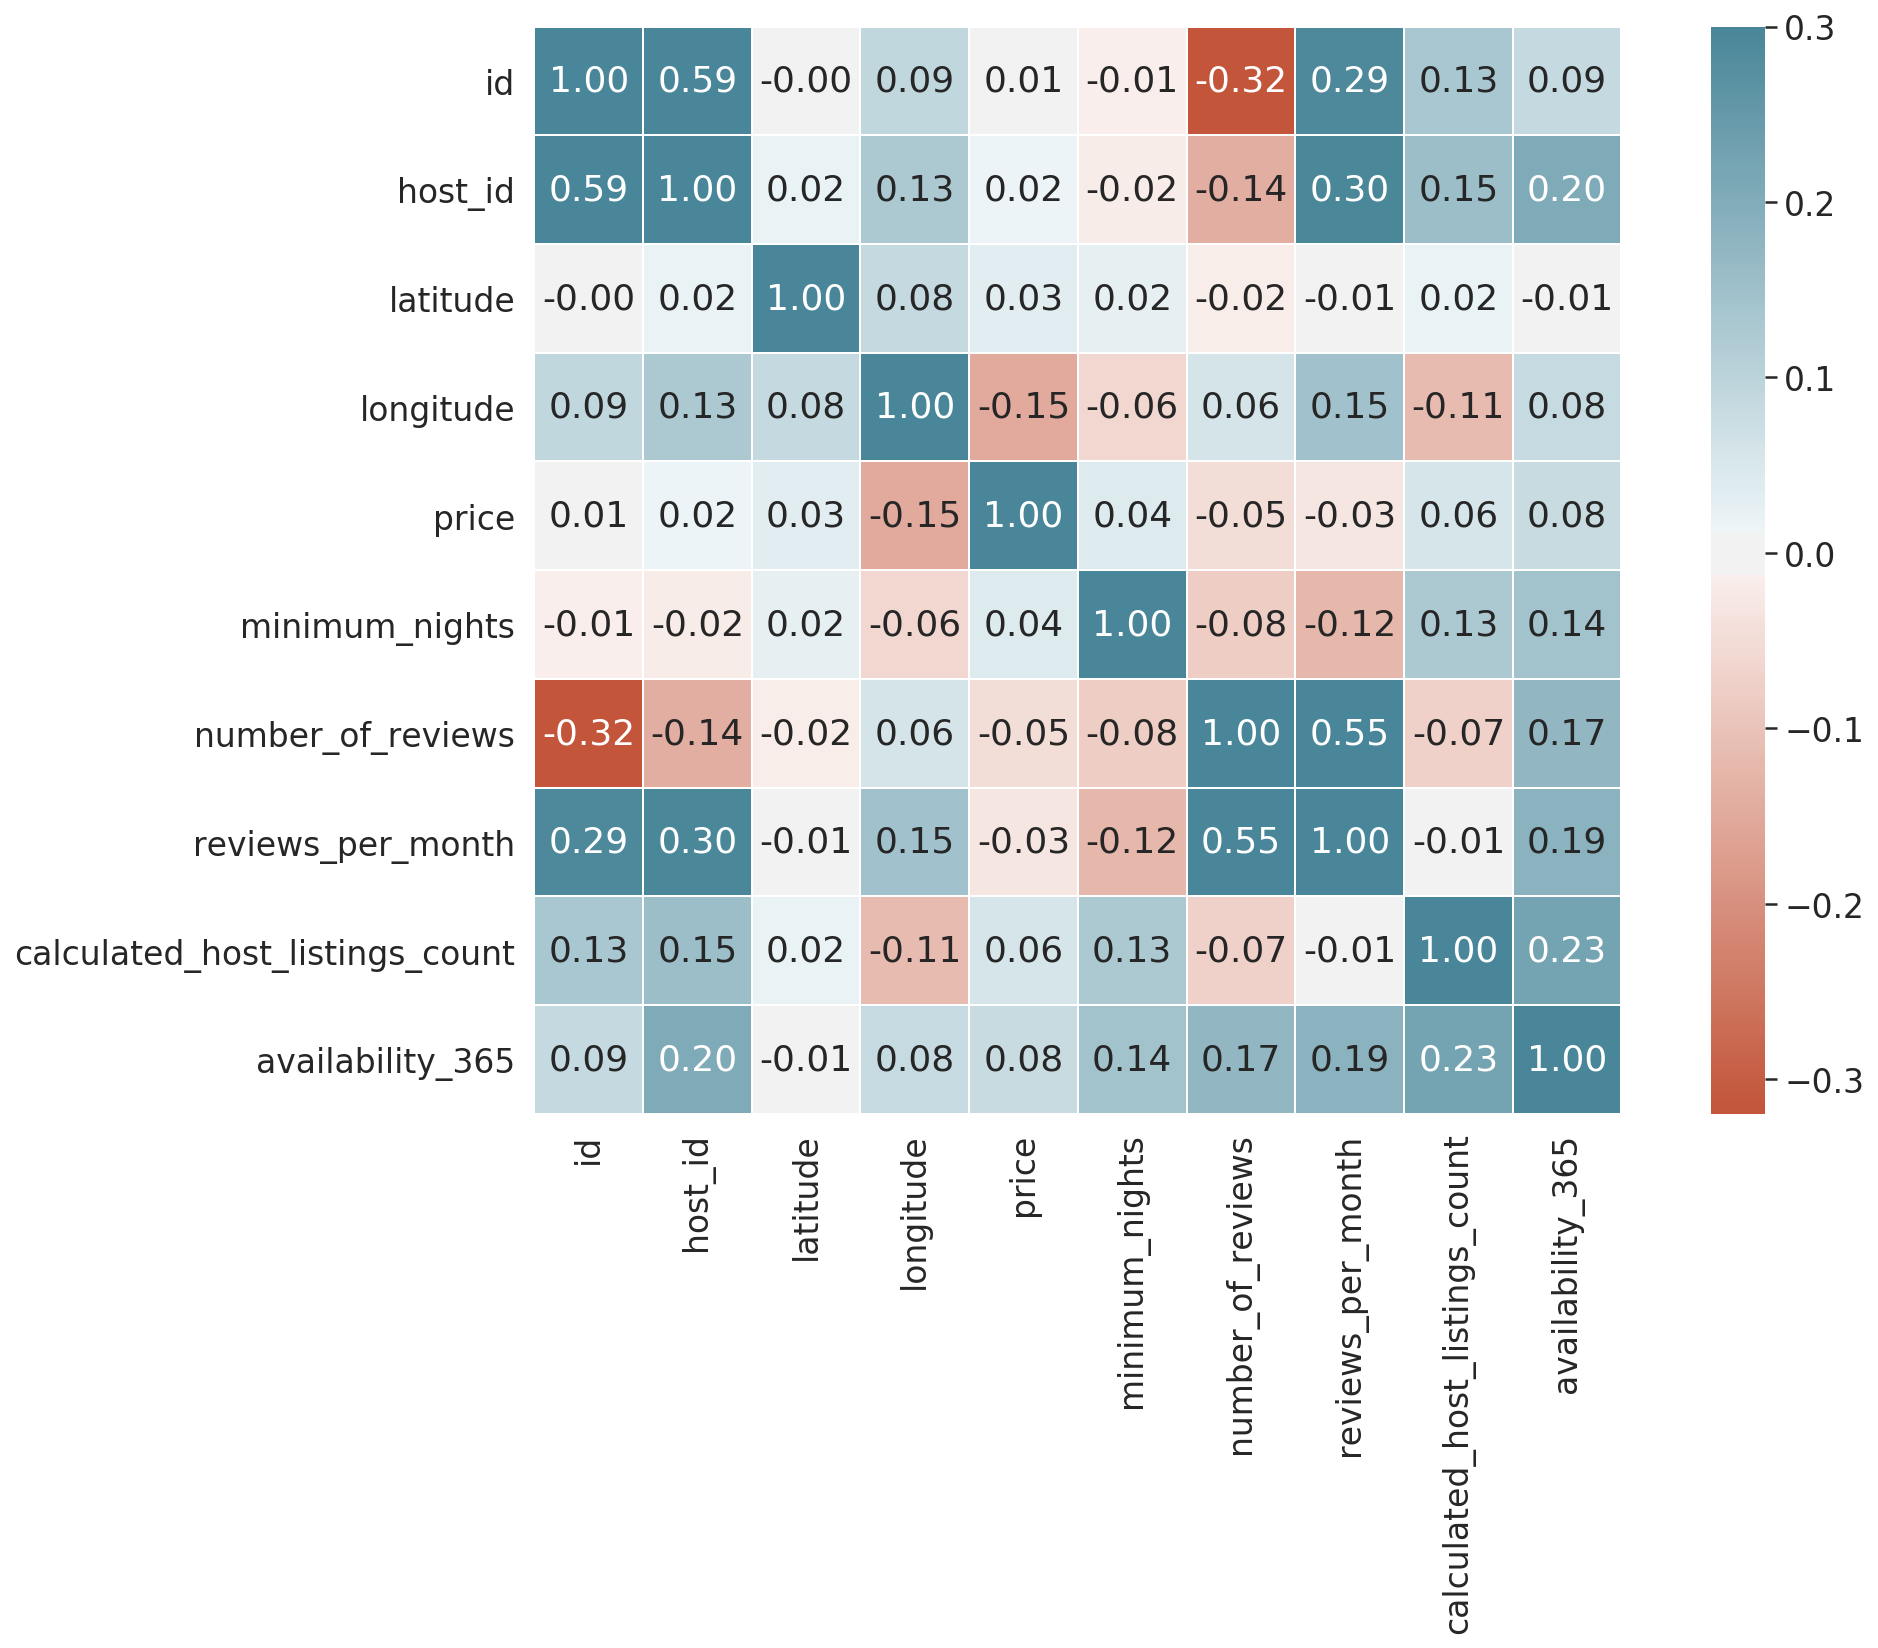

In [24]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

# Preprocessing




## Missing data?

In [25]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

reviews_per_month    10052
last_review          10052
host_name               21
name                    16
dtype: int64

## Remove unused columns!


In [26]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'reviews_per_month', 'last_review', 'neighbourhood'], axis=1)

In [27]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [28]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [29]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Predict log1p

In [30]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)

## Feature scaling and One-hot encoding

In [31]:
from sklearn.preprocessing import OneHotEncoder

data = [['Manhattan'], ['Brooklyn']]

OneHotEncoder(sparse=False).fit_transform(data)

array([[0., 1.],
       [1., 0.]])

In [32]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (MinMaxScaler(), ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']),
    (OneHotEncoder(handle_unknown="ignore"), ['neighbourhood_group', 'room_type'])
)

In [33]:
transformer.fit(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['neighbourhood_group', 'room_type'])],
                  verbose=False)

In [34]:
X = transformer.transform(X)

## Split the training and test data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
X_train.shape

(39116, 14)

# Modeling

In [37]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

Train on 31292 samples, validate on 7824 samples
Epoch 1/100
31292/31292 [==============================] - 2s 55us/sample - loss: 8.6985 - mse: 8.6985 - val_loss: 0.5412 - val_mse: 0.5412
Epoch 2/100
31292/31292 [==============================] - 1s 41us/sample - loss: 2.3424 - mse: 2.3424 - val_loss: 0.4477 - val_mse: 0.4477
Epoch 3/100
31292/31292 [==============================] - 1s 42us/sample - loss: 2.1386 - mse: 2.1386 - val_loss: 0.4236 - val_mse: 0.4236
Epoch 4/100
31292/31292 [==============================] - 1s 38us/sample - loss: 1.9759 - mse: 1.9759 - val_loss: 0.4252 - val_mse: 0.4252
Epoch 5/100
31292/31292 [==============================] - 1s 39us/sample - loss: 1.9401 - mse: 1.9401 - val_loss: 0.4459 - val_mse: 0.4459
Epoch 6/100
31292/31292 [==============================] - 1s 41us/sample - loss: 1.8728 - mse: 1.8728 - val_loss: 0.4093 - val_mse: 0.4093
Epoch 7/100
31292/31292 [==============================] - 1s 41us/sample - loss: 1.7967 - mse: 1.7967 - val_lo

Epoch 59/100
31292/31292 [==============================] - 1s 40us/sample - loss: 0.3110 - mse: 0.3110 - val_loss: 0.2487 - val_mse: 0.2487
Epoch 60/100
31292/31292 [==============================] - 1s 41us/sample - loss: 0.3067 - mse: 0.3067 - val_loss: 0.2493 - val_mse: 0.2493
Epoch 61/100
31292/31292 [==============================] - 1s 40us/sample - loss: 0.3045 - mse: 0.3045 - val_loss: 0.2497 - val_mse: 0.2497
Epoch 62/100
31292/31292 [==============================] - 1s 39us/sample - loss: 0.3010 - mse: 0.3010 - val_loss: 0.2487 - val_mse: 0.2487
Epoch 63/100
31292/31292 [==============================] - 1s 42us/sample - loss: 0.2943 - mse: 0.2943 - val_loss: 0.2466 - val_mse: 0.2466
Epoch 64/100
31292/31292 [==============================] - 1s 39us/sample - loss: 0.2878 - mse: 0.2878 - val_loss: 0.2476 - val_mse: 0.2476
Epoch 65/100
31292/31292 [==============================] - 1s 40us/sample - loss: 0.2891 - mse: 0.2891 - val_loss: 0.2480 - val_mse: 0.2480
Epoch 66/100


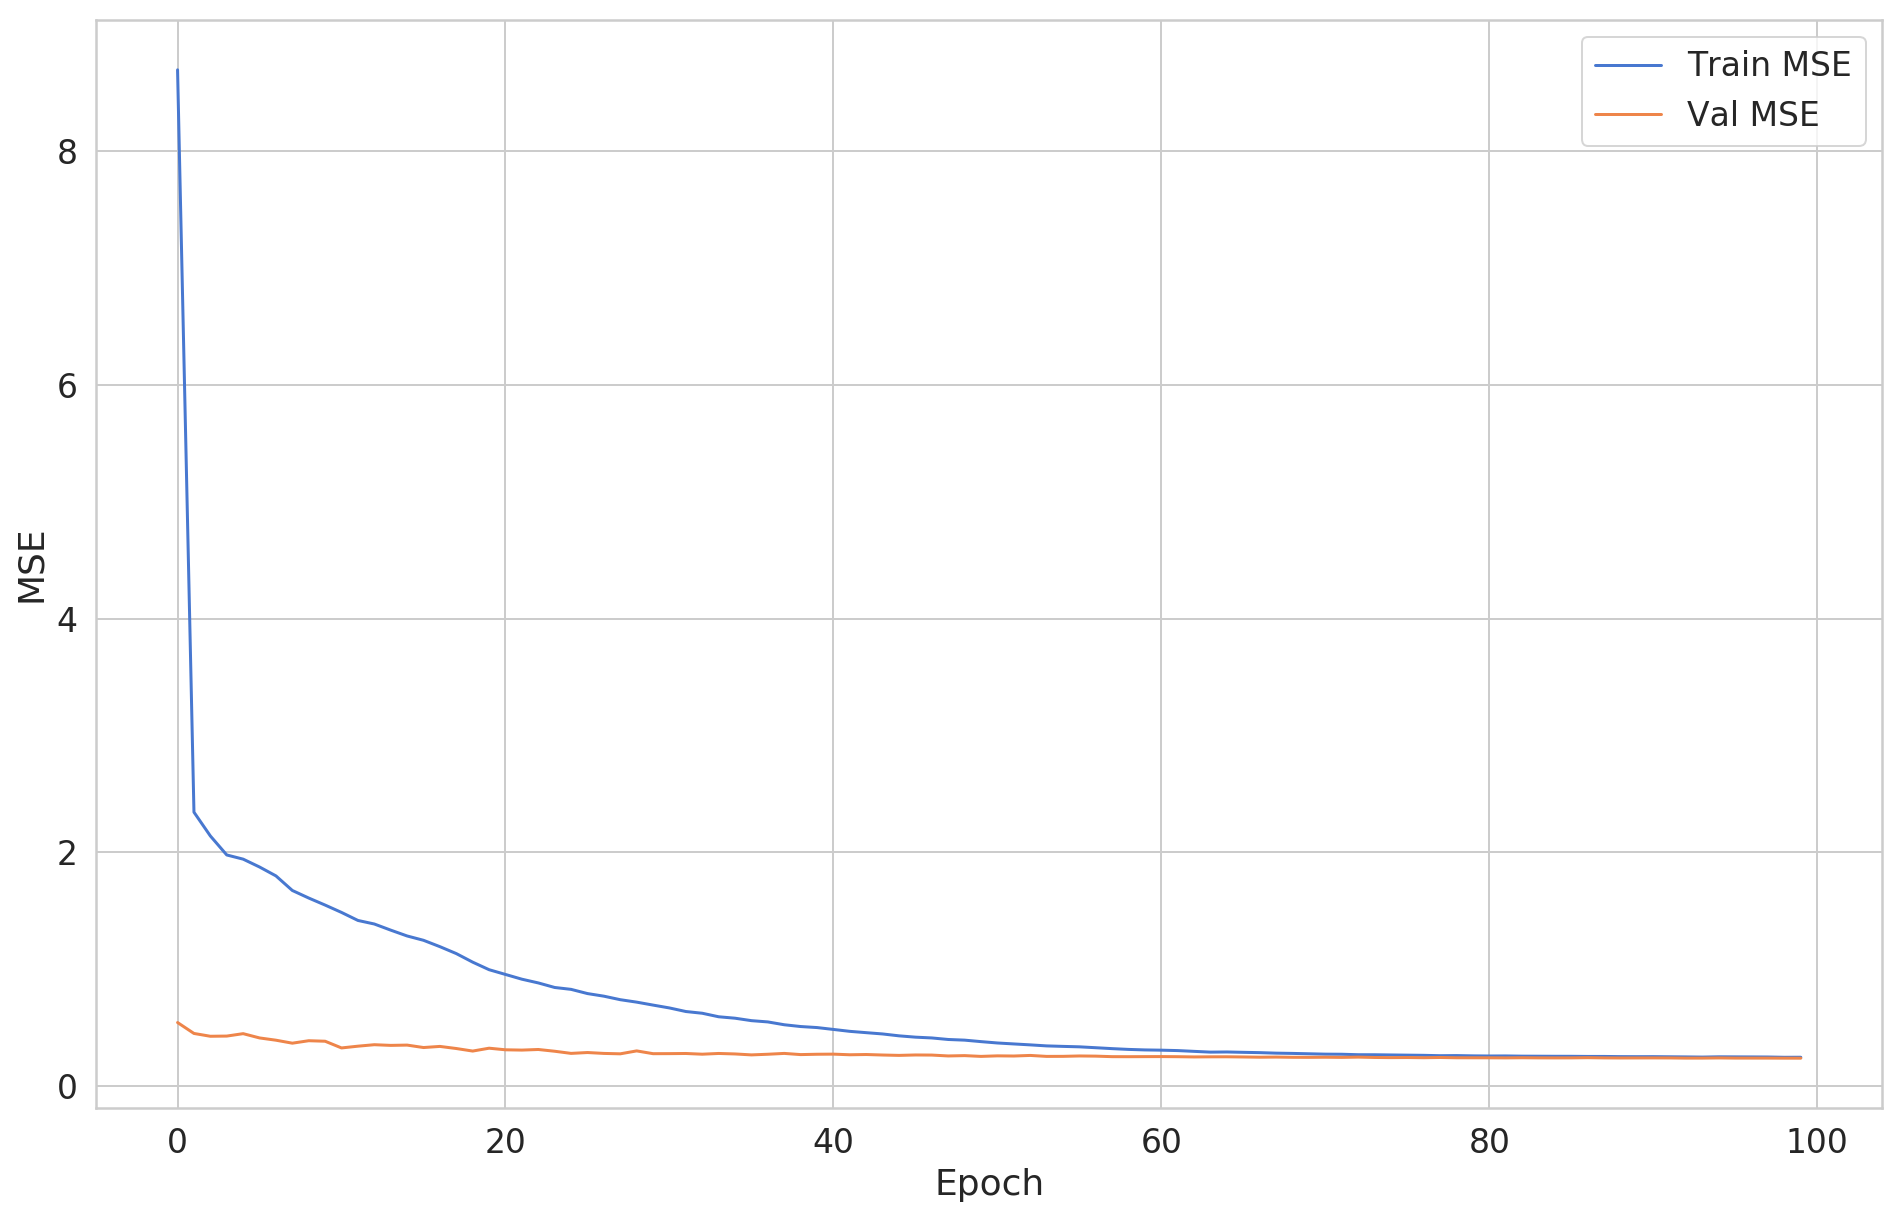

In [38]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

plot_mse(history)

# Evaluation

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [54]:
print(X_test.shape,y_test.shape)

(9779, 14) (9779,)


In [40]:
y_pred = model.predict(X_test)

In [42]:
print(mean_squared_error(y_test, y_pred))

0.21233864692177748


In [43]:
print(mean_absolute_error(y_test, y_pred))

0.3322096946409984


In [44]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.4608021776443526


In [45]:
print(r2_score(y_test, y_pred))

0.55116428363327


# Saving

In [46]:
joblib.dump(transformer, "data_transformer.joblib")
model.save("price_prediction_model.h5")

# Loading

In [47]:
from google.colab import files

ImportError: No module named 'google.colab'

In [48]:
files.download("data_transformer.joblib")
files.download("price_prediction_model.h5") 

NameError: name 'files' is not defined